## Fit & Validate A Logistic Regression and Generate Related Visualizations

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, auc, roc_curve

In [2]:
df = pd.read_csv("../data/df_mvp.csv")

In [5]:
df.head()

,time_bin,label,source,current_popularity,wind_speed,temp,status_good,status_maybe,status_bad,dayofweek,hour
0,2020-03-23 14:35:00,0.0,mis/imp,42.0,26.598094,37.846753,0.0,0.0,1.0,0,14
1,2020-03-23 14:50:00,0.0,obs,42.0,25.900000,37.940000,0.0,0.0,1.0,0,14
2,2020-03-23 15:05:00,0.0,mis/imp,43.0,26.427817,38.125302,0.0,0.0,1.0,0,15
3,2020-03-23 15:20:00,0.0,mis/imp,43.0,28.181545,38.402658,0.0,0.0,1.0,0,15
4,2020-03-25 12:50:00,0.0,mis/imp,31.0,18.400000,42.080000,1.0,0.0,0.0,2,12


### Generate a correlation plot to test for predictor multicollinearity & remove multicollinear variables

In [3]:
import seaborn as sns 

corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title("Predictor Correlations")
fig = ax.get_figure()
fig.savefig("../src/d06_visuals/modeling_logistic_correlation_plot.png", dpi=300, bbox_inches='tight')
# fig.show()

#### Since status_maybe is highly collinear with status_good, we will remove status_maybe.

In [4]:
# Get just the unprocessed predictor columns
pred = df.drop(['label','time_bin','source','status_maybe'],axis=1)

# Standardize the predictors
scaler = StandardScaler()
scaler.fit(pred)

# # Define the predictors that we will train on
X = scaler.transform(pred)

# Save the response variable separately
y = df.label

In [5]:
# Split the training from the test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Initialize our classifier
clf = LogisticRegression(random_state=42)

# Fit our classifier
clf_fit = clf.fit(X_train, y_train)

# Validate our classifier
y_score = clf_fit.predict(X_test)
y_pred_proba = clf_fit.predict_proba(X_test)[:,-1]


accuracy = accuracy_score(y_test, y_score)
precision = precision_score(y_test, y_score)
recall = recall_score(y_test, y_score)
false_pos, true_pos, _ = roc_curve(y_test, y_pred_proba, pos_label=1.0)
area_under_curve = auc(false_pos,true_pos)

f = open("../src/d05_reporting/modeling_metrics_logistic", 'w')
f.write("accuracy: "+str(np.round(accuracy,3))+"\n")
f.write("precision: "+str(np.round(precision,3))+"\n")
f.write("recall: "+str(np.round(recall,3))+"\n")
f.write("ROC AUC: "+str(np.round(area_under_curve,3)))
f.close()

/home/eric/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


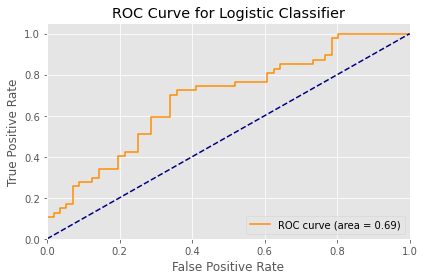

In [7]:
# Plot ROC curve
import matplotlib.pyplot as plt
plt.style.use("ggplot")

plt.plot(false_pos, true_pos, color='darkorange',
label='ROC curve (area = %0.2f)' % area_under_curve)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Classifier')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("../src/d06_visuals/modeling_logistic_ROC.png")
#plt.show()

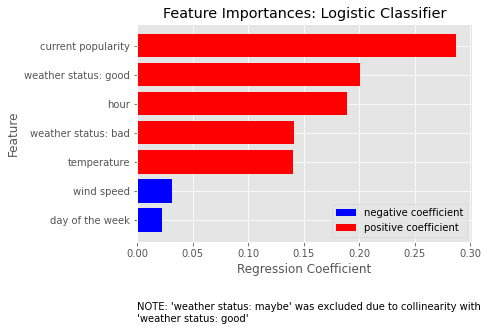

In [8]:
# Plot feature importances
col = ['current popularity', 'wind speed', 'temperature', 'weather status: good',
       'weather status: bad', 'day of the week', 'hour']

def colormap(negative):
    ans = []
    for i in range(0,len(negative)):
        if negative[i] == True:
            ans.append('blue')
        else:
            ans.append('red')
    return ans

colorname = colormap([clf.coef_[0] < 0][0])

xyd = {'variable':col, 'coefficient':abs(clf.coef_[0]), 'negative':colorname}

xy = pd.DataFrame(xyd)
xy = xy.sort_values('coefficient', ascending = True)

bar = plt.barh(width = xy.coefficient, y = xy.variable, color = xy.negative)
plt.title("Feature Importances: Logistic Classifier")
plt.ylabel("Feature")
plt.xlabel("Regression Coefficient")
plt.legend(handles=(bar[0],bar[2]),labels=('negative coefficient','positive coefficient'),loc='lower right')
# This is a bit of a hack. We exploit the fact that bar[0] happens to
# have a negative coefficient and bar[2] happens to have a positive one.
txt = "NOTE: 'weather status: maybe' was excluded due to collinearity with\n'weather status: good'"
plt.text(0,-3.5,txt)
plt.savefig("../src/d06_visuals/modeling_logistic_feature_importances.png", bbox_inches = 'tight')